# Optimize and train GPT-2

## Establishing a timing baseline

![](./assets/gpu-usage-init.png)

- Each iteration would take about 720ms with batch size of 10 on a 3090 (vs 1000 on A100 with double the batch size!), so I expect my single-GPU training to be a bit slower than Andrej's.  With Andrej's A100, it's possible to process one epoch in 20 batches of size 16 with about 1000ms/batch, whereas with a 3090, it's possible to process one epoch in 33 batches of size 10 with 730ms/batch, so about 20% slower than Andrej's time (33x730/20x1000).
- Also, Andrej suggests using nice numbers that have lots of multiples of 2.  I tried a batch size of 8, but in this specific use case, I found that using batch size of 10 vs 8 is slightly faster per epoch on a 3090. 

- Also, to properly time the code, it's important to wait until the GPU processes a batch before the CPU times the work.  It's possible that the CPU has loaded a batch onto GPU, GPU is still processing it, and the CPU has moved on to record the end time for the operation. To prevent this from happening, use torch.cuda.synchronize():

In [ ]:
train_loader = DataLoaderLite(B=10,T=1024)
model = GPT(GPTConfig())
model.to(device)
# create an optimizer object
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):
    t0 = time.time()
    x,y = train_loader.next_batch()
    x,y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x,y)
    #import code; code.interact(local=locals())
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize() # wait for GPU to finish all the scheduled work
    t1= time.time()
    dt = (t1-t0)*1000 # time diff in seconds
    tokens_per_sec = (train_loader.B*train_loader.T)/(t1-t0)
    print(f'iteration {i}, loss = {loss.item()}, dt: {dt: .2f}ms, toks/sec: {tokens_per_sec:.2f}')

- We may change the batch size, so to get a more objective measure of training speed, look at tokens/second, which is 16.3K on an A100 and 14.1K on a 3090.

## Mixed precision logic

- First observe that we can check the type of the logits in our model by starting an interactive debugging session as below:

In [ ]:
train_loader = DataLoaderLite(B=4,T=32)
model = GPT(GPTConfig())
model.to(device)
# create an optimizer object
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):
    x,y = train_loader.next_batch()
    x,y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x,y)
    import code; code.interact(local=locals())
    loss.backward()
    optimizer.step()
    print(f'iteration {i}, loss = {loss.item()}')
    

- Which yields

In [2]:
(InteractiveConsole)
>>> logits.dtype
torch.float32

- PyTorch supports up to FP64 precision, which is useful for scientific computing applications, but deep learning training can tolerate significantly lower precision than default FP32, however. 
- From A100 spec sheet, for example, it's possible to get 16x performance improvement by going down from FP32 to FP16 Tensor Core.
- For deep learning, sparsity feature is not currently used, so disregard the second number in a cell when it's present.
- We do not use INT8 for training since it implies a uniform distribution and we need a normal distribution provided by the float data types. INT8 is used for inference, however.
- The memory bandwidth of an A100 is 1935GB/s, and most well-tuned application are bound more by memory than by speed.  Lowering precision means tensors will take less space in memory, making it easier to satisfy the memory bandwidth constraint.  
- To summarize, by lowering precision, "we can store more and access it faster" (Andrej).

![Source: https://developer.nvidia.com/blog/nvidia-ampere-architecture-in-depth/](./assets/a100-specs-short.png)

## Tensor Cores

![Source: https://developer.nvidia.com/blog/programming-tensor-cores-cuda-9/](./assets/tensor-core.png)

- A Tensor Core is an instruction in a given architecture, in the case above for a 4x4 multiply and add operations.  Any time we have multiply (and less importantly add) operations, which compose the majority of our GPT-2 transformer, these operations will be performed using Tensor Cores.  For example, the classifier head matrix multiply going from 768 to 50257 dominates the computations in GPT-2.

![Source: https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf](./assets/tf32.png)

- With FP32 (torch.float32 default of PyTorch), both the input operands and the intermediate add/multiplies that compose individual elements of the result matrix are done in FP32. 
- We could switch to TF32, however, which uses the full 32 bits of FP32 for accumulator but just 19 bits for input operands due to lower number of mantissa bits as seen below:

![Source: https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf](./assets/exponent-mantissa.png)

- With TF32, we get an 8x speedup without needing to modify the code.  The outputs will still be in FP32 as seen below.  If our application can tolerate a little bit of imprecision, TF32 is a great option.  In practice,the difference between FP32 and TF32 is almost imperceptible. 

![Source: https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf](./assets/tf32-mechanics.png)

- On my 24GB 3090, I was able to use batch size of 8 (or 10 max) with sequence length of 1024 (Andrej got away with batch size of 16 on 40GB A100):

## Compute the speedup with TF32

- To enable TF32 in PyTorch, change the float32 matmul precision from it's default 'highest' to 'high' with torch.set_float32_matmul_precision('high'):

In [ ]:
train_loader = DataLoaderLite(B=10,T=1024)

torch.set_float32_matmul_precision('high')
...
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):
   ...

- On an A100, throughput increases from 16.1K tokens/second to about 49K tokens/second, so *about a 3X speedup*. 
- On 3090, this leads to *only about 40% speedup* from 14.1K tokens/second baseline to 19.6K tokens/second.  
- While TF32 in principle offers an 8X speedup on an A100 (I couldn't find reliable official estimates for 3090 TF32 *tensor*), a lot of these workloads are memory bound.  Thus although a matrix multiplication could potentially happen 8X faster with TF32 compared to FP32, the output numbers are still FP32, and these get moved around through the memory system at a speed that's much slower than the GPU's ability to perform the calculations.  

## Bfloat16 to reduce memory bandwidth constraint 

- Let's review the following once again

![Source: https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf](./assets/exponent-mantissa.png)

- To address the memory bandwidth constraint, we can use Bfloat16 (BF16) to more aggressively crop the mantissa without changing the sign and exponent (range) of the number.  
- Originally, FP16 was used, but this number format has a reduced range, causing issues that were patched by gradient scalers and similar solutions that introduced additional state and complexity. BF16 addresses these problems by preserving the original range of number.
- Andrej recommends studying the torch.autocast portion of [mixed precision documentation](https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html), which has a context manager *torch.autocast*.  This context manager is recommended around forward pass and loss calculation of the model only.
- We thus only need to add one line of code as below:

In [ ]:
for i in range(50):
    ...
    optimizer.zero_grad()
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x,y)
    loss.backward()
    ...

- Using an interactive console breakpoint

In [14]:
for i in range(50):
    ...
    optimizer.zero_grad()
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x,y)
        import code; code.interact(local=locals())

    loss.backward()
    ...

- We see that logits.dtype is indeed torch.bfloat16.  Our weights remain in FP32, however, as model.transformer.wte.weight.dtype is torch.float32.  This implies a mixed precision: PyTorch is keeping certain weights in full precision while converting others to bfloat16.  What gets converted at what point is not exactly clear, but the general guidelines are below:

![Source: https://pytorch.org/docs/stable/amp.html](./assets/tf32-vs-bfloat16-what-converts.png)

- Thus matrix multiplications, addition, etc. get converted while layer norms, softmax, etc. do not since they are less robust to precision changes.

- On an A100, our previous benchmark is 50K tokens/second and it goes up to 55K tokens/second with bfloat16, about a 10% speedup.
- On a 3090, our previous benchmark is 19.6K tokens/second and it goes up to 27.5K tokens/second with bfloat16, about a 40% speedup, suggesting that 3090 was perhaps more memory-bound than the A100.


## Torch.compile, a compiler for neural networks

In [ ]:
train_loader = DataLoaderLite(B=10,T=1024)

torch.set_float32_matmul_precision('high')

model = GPT(GPTConfig())
model.to(device)
# torch.compile only needs a single line
model = torch.compile(model)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):
    ...

- The first iteration with torch.compile will typically be slower since PyTorch takes time to compile the code at the start.
- On an A100 with batch size of 16, Andrej observed a 2.3x improvement from using torch.compile. 
- On a 3090 with batch size of 10, no improvement was seen during the first run (27.4 K tokens/second -> 26.8K tokens/second). However, switching down to batch size of 8 yielded a significant increase *the first time around*.  However, when I repeated the experiment, torch.compile ended up being faster with batch size of 10 again!  This could have been due to graph breaks or kernel launch overhead.  
- Taking the best runtime with torch.compile and batch size of 10, 27.4 K -> 41.7 K tokens/second, or about 48% speedup over mixed precision benchmark. 

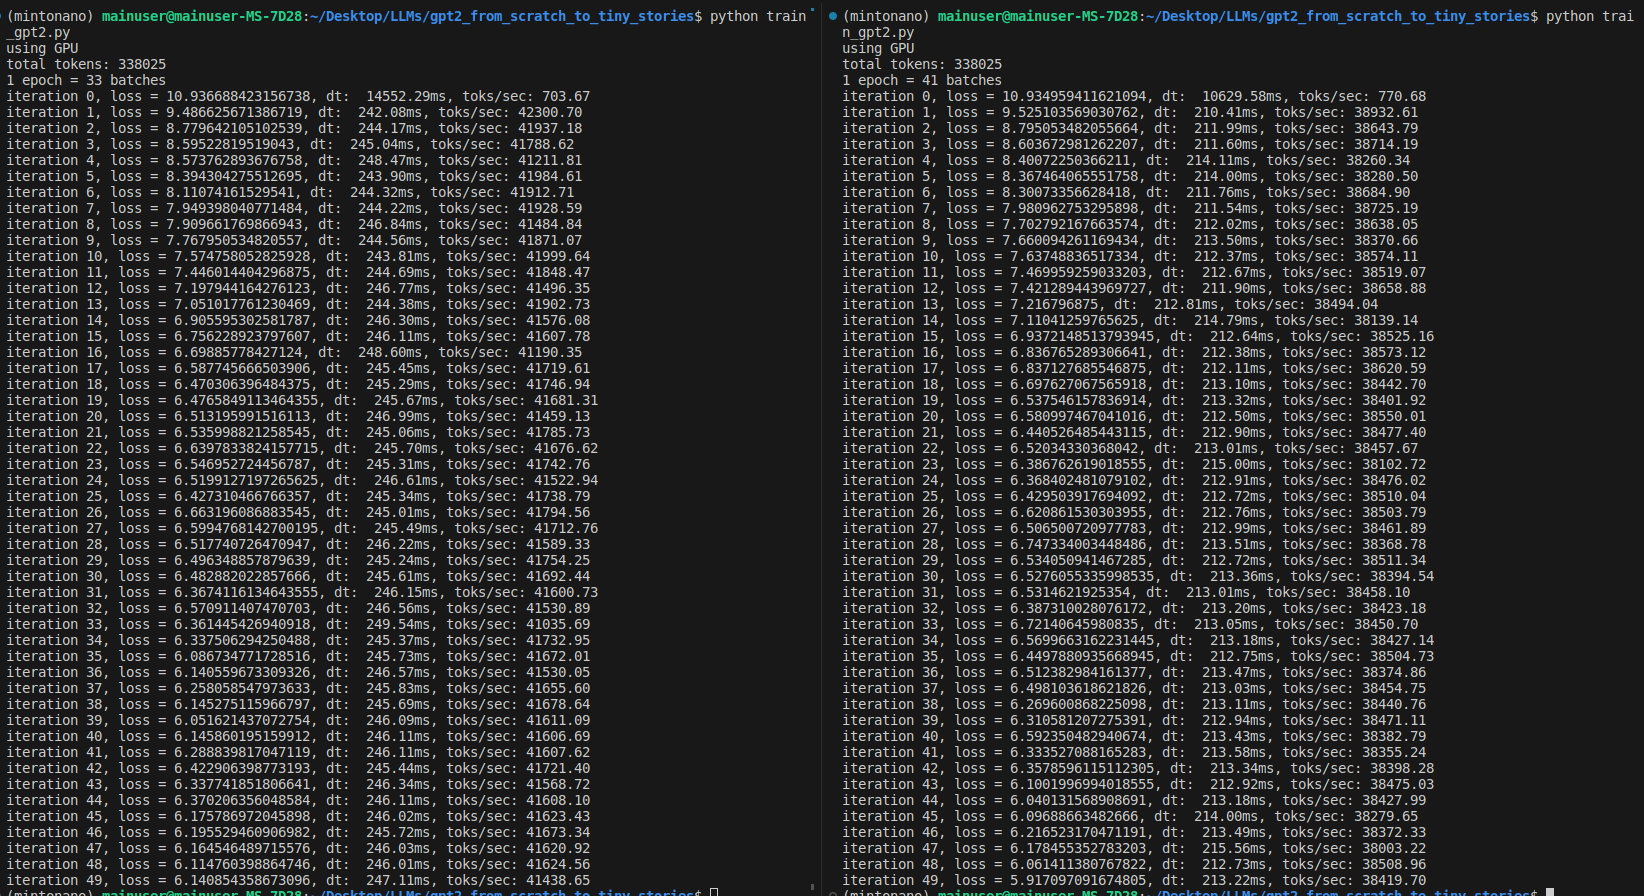

- torch.compile does the following:
    - Take out the Python interpreter from the forward pass and compile the neural net as a single object
    - Reduce GPU read/writes as demonstrated in the following example. Suppose we didn't use torch.compile and instead of nn.GELU in our MLP, we used our own custom implementation below:
    ```python
    class TanhGELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi)*(x + 0.044715 * torch.pow(x, 3.0))))
    ```
    - Looking at the following [diagram](https://developer.nvidia.com/blog/improving-gpu-memory-oversubscription-performance/), the input would first need to be placed from the High-Bandwidth Memory (HBM) onto the GPU for the torch.pow(x, 3.0) computation.  Once the results are computed, they would be sent back to HBM.  Next the computed result would be sent back to be multiplied by 0.044715 and so on. This would results many reads and writes to and from GPU and HBM, which are the bottleneck in many modern system.
    - Since all the operations in the custom TanhGELU are element-wise operations, torch.compile can move the input to GPU and, for every single element, perform all the operations while the memory is on the GPU, then write back a single time.  This is an example of *kernel fusion*, a major way in which torch.compile creates a speedup.  

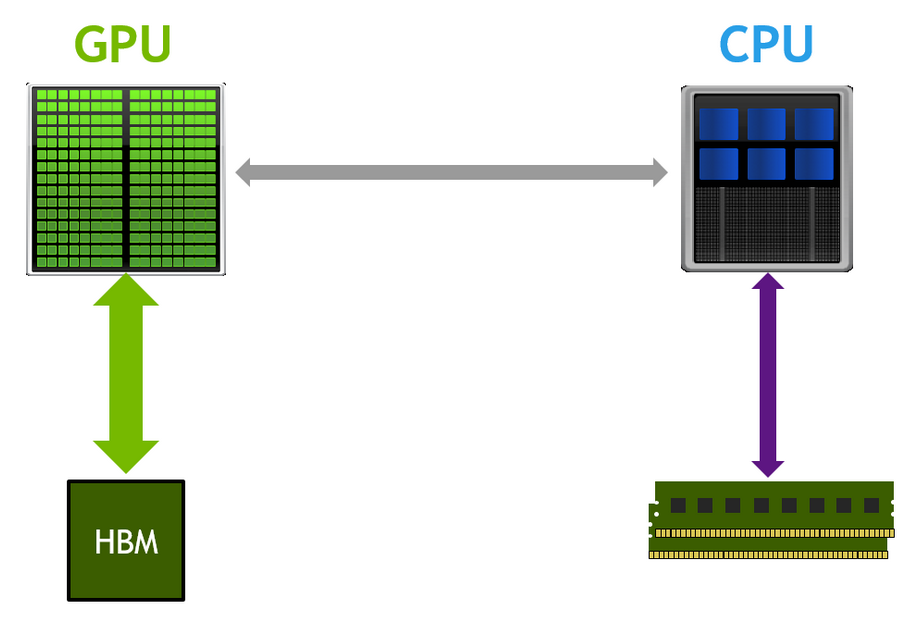

- In addition, when the data is moved to GPU for element-wise operations, it will need intermediate memory, a small amount of which is found on the GPU. Andrej points out that on the GPU chip itself, there is L2 cache. On the streaming multiprocessors (SMs) that do the calculation, there's L1 memory and registers.  These use SRAM for fast access times and low power consumption vs transistors and capacitors implementation of HBM.  Below is a typical diagram of memory and associated access speeds from Dao et al. (2022), Figure 1:

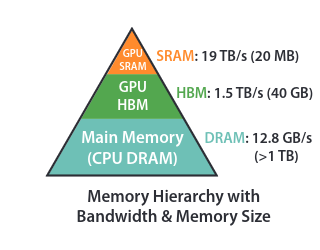


- With mixed precision and torch.compile optimizations, Andrej's training on an A100 is about 3X faster than training on a 3090, with 125K tokens/second processed on an A100 and 41.5K tokens/second on a 3090.

## FlashAttention

- The attention operation is currently composed of the four lines of code highlighted below:

In [6]:

class CausalSelfAttention(nn.Module):
    def __init__(self, config) -> None:
        ...
    def forward(self, x):
        ...
        v = v.view(B, T, self.n_head, C//self.n_head).transpose(1,2)
        # -----Start: attention operation-----
        att = (q @ k.transpose(-2,-1))*(1.0/math.sqrt(k.size(-1))) # (B, nh, T, hs) x (B, nh, hs, T) = (B, nh, T, T)
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) = (B, nh, T, hs)
        # -----End: attention operation-----
        y = y.transpose(1,2).contiguous().view(B, T, C) 
        ...


- FlashAttention is a kernel fusion operation that torch.compile cannot find currently.  This is because kernel fusion requires an algorithmic rewrite of how attention is currently implemented.  While FlashAttention requires more FLOPs, it ends up being significantly faster because of its judicious use of the memory hierarchy, which leads to fewer read/writes between GPU and HBM.  
- In particular, the NxN attention matrix is never read from/written to HBM.  It's simple to perform the matrix multiplications in a streaming manner, but computing softmax this way is more of a challenge.  The crux of the algorithmic rewrite is the online softmax trick, which incrementally computes the softmax without needing all the inputs as is customary for standard softmax normalization.  The key insight is that the softmax function can be broken down into smaller chunks, computed independently on GPU, and then combined using a 'softmax trick' formula. This enables FlashAttention to process long sequences more efficiently, without having to materialize the entire attention matrix at once.  
- In more detail, from p.5 of Dao et al. (2022), the softmax trick uses intermediate *m* and *l* variables that combine the statistics from individual 'attention submatrices' to reconstruct the softmax for the entire attention matrix.  
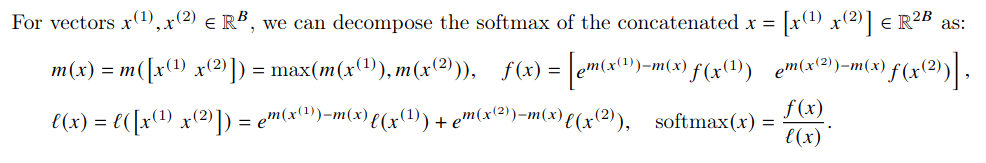


- With FlashAttention in place, the four lines above become one line in the following code:

In [ ]:

class CausalSelfAttention(nn.Module):
    def __init__(self, config) -> None:
        ...
    def forward(self, x):
        ...
        v = v.view(B, T, self.n_head, C//self.n_head).transpose(1,2)
        # -----Start: attention operation-----
        y = F.scaled_dot_product_attention(q,k,v, is_causal=True)
        # -----End: attention operation-----
        y = y.transpose(1,2).contiguous().view(B, T, C) 
        ...


- The loss after 50 iterations is identical to what it was before since FlashAttention is *exact* attention, not an approximation, so identical operations are performed.  However, 
on a 3090, with FlashAttention added, about 50K tokens/second can be processed compared 41.7K tokens/second with just mixed precision+torch.compile, hence about a 20% speedup.  On an A100, Andrej obtained about a 27% improvement.  

## References

Dao, Tri, Daniel Y. Fu, Stefano Ermon, Atri Rudra, and Christopher Ré. "FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness." arXiv preprint arXiv:2205.14135v2 (2022).